In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torch.utils.data import DataLoader

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

ModuleNotFoundError: No module named 'torch'

In [2]:
# Root directory for dataset
dataroot = "../dataset"

workers = 2
batch_size = 128

image_size = 64
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 20

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
# Note transforms.ToTensor() scales input images
# to 0-1 range
mnist_data = dset.MNIST(root=dataroot, 
                               train=True, 
                               transform = transforms.Compose(
                                    [
                                        transforms.Resize(64),
                                        transforms.ToTensor()
                                    ]),
                               download=True)

dataloader = DataLoader(dataset=mnist_data, 
                          batch_size=batch_size, 
                          shuffle=True)
# Checking the dataset
for images, labels in dataloader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([128, 1, 64, 64])
Image label dimensions: torch.Size([128])


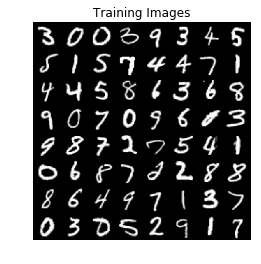

In [4]:
# Decide which device we want to run on
device = torch.device("cuda:1" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(4,4))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [6]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [7]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [8]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [9]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [10]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
# Training Loop

import time 
start = time.time()

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())
        
        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1
        
    print('Elapsed time {:f} min'.format((time.time()-start)/60))

Starting Training Loop...
[0/20][0/469]	Loss_D: 2.2322	Loss_G: 3.4823	D(x): 0.4135	D(G(z)): 0.6264 / 0.0436
[0/20][50/469]	Loss_D: 0.0519	Loss_G: 7.6327	D(x): 0.9814	D(G(z)): 0.0303 / 0.0007
[0/20][100/469]	Loss_D: 0.2121	Loss_G: 7.6117	D(x): 0.9516	D(G(z)): 0.1371 / 0.0009
[0/20][150/469]	Loss_D: 0.9805	Loss_G: 4.0276	D(x): 0.9962	D(G(z)): 0.4779 / 0.0607
[0/20][200/469]	Loss_D: 0.2284	Loss_G: 4.0907	D(x): 0.9059	D(G(z)): 0.1087 / 0.0251
[0/20][250/469]	Loss_D: 0.1433	Loss_G: 4.2292	D(x): 0.9104	D(G(z)): 0.0405 / 0.0211
[0/20][300/469]	Loss_D: 0.1611	Loss_G: 3.4759	D(x): 0.9213	D(G(z)): 0.0706 / 0.0417
[0/20][350/469]	Loss_D: 0.1158	Loss_G: 4.6444	D(x): 0.9802	D(G(z)): 0.0884 / 0.0126
[0/20][400/469]	Loss_D: 0.9643	Loss_G: 1.0816	D(x): 0.5164	D(G(z)): 0.0920 / 0.4071
[0/20][450/469]	Loss_D: 0.1228	Loss_G: 3.3210	D(x): 0.9357	D(G(z)): 0.0507 / 0.0492
Elapsed time 0.964507 min
[1/20][0/469]	Loss_D: 0.0881	Loss_G: 4.1763	D(x): 0.9690	D(G(z)): 0.0532 / 0.0224
[1/20][50/469]	Loss_D: 0.0745

[9/20][250/469]	Loss_D: 0.0228	Loss_G: 5.8455	D(x): 0.9906	D(G(z)): 0.0118 / 0.0054
[9/20][300/469]	Loss_D: 0.0115	Loss_G: 6.0174	D(x): 0.9984	D(G(z)): 0.0098 / 0.0047
[9/20][350/469]	Loss_D: 0.0088	Loss_G: 6.8056	D(x): 0.9936	D(G(z)): 0.0023 / 0.0025
[9/20][400/469]	Loss_D: 0.9786	Loss_G: 1.2029	D(x): 0.6418	D(G(z)): 0.3430 / 0.3426
[9/20][450/469]	Loss_D: 0.7724	Loss_G: 1.6297	D(x): 0.5837	D(G(z)): 0.1038 / 0.2676
Elapsed time 9.766524 min
[10/20][0/469]	Loss_D: 0.4627	Loss_G: 2.2546	D(x): 0.7414	D(G(z)): 0.1025 / 0.1417
[10/20][50/469]	Loss_D: 0.5722	Loss_G: 2.3901	D(x): 0.8684	D(G(z)): 0.2779 / 0.1328
[10/20][100/469]	Loss_D: 0.6095	Loss_G: 2.9257	D(x): 0.9446	D(G(z)): 0.3583 / 0.0872
[10/20][150/469]	Loss_D: 0.3453	Loss_G: 7.5395	D(x): 0.9623	D(G(z)): 0.2313 / 0.0009
[10/20][200/469]	Loss_D: 0.0398	Loss_G: 4.9764	D(x): 0.9836	D(G(z)): 0.0221 / 0.0146
[10/20][250/469]	Loss_D: 0.0324	Loss_G: 5.1266	D(x): 0.9779	D(G(z)): 0.0097 / 0.0134
[10/20][300/469]	Loss_D: 0.0196	Loss_G: 5.8230	

[18/20][450/469]	Loss_D: 0.0035	Loss_G: 7.5199	D(x): 0.9976	D(G(z)): 0.0011 / 0.0012
Elapsed time 18.545997 min
[19/20][0/469]	Loss_D: 0.0073	Loss_G: 6.4916	D(x): 0.9977	D(G(z)): 0.0049 / 0.0033
[19/20][50/469]	Loss_D: 0.0103	Loss_G: 6.2881	D(x): 0.9955	D(G(z)): 0.0057 / 0.0044
[19/20][100/469]	Loss_D: 0.0073	Loss_G: 6.8517	D(x): 0.9959	D(G(z)): 0.0031 / 0.0024
[19/20][150/469]	Loss_D: 0.0033	Loss_G: 7.1315	D(x): 0.9986	D(G(z)): 0.0018 / 0.0019
[19/20][200/469]	Loss_D: 0.0161	Loss_G: 6.2100	D(x): 0.9942	D(G(z)): 0.0095 / 0.0058
[19/20][250/469]	Loss_D: 0.0035	Loss_G: 6.9099	D(x): 0.9986	D(G(z)): 0.0021 / 0.0025
[19/20][300/469]	Loss_D: 0.0027	Loss_G: 6.9353	D(x): 0.9987	D(G(z)): 0.0014 / 0.0019
[19/20][350/469]	Loss_D: 0.0069	Loss_G: 7.0813	D(x): 0.9985	D(G(z)): 0.0053 / 0.0015
[19/20][400/469]	Loss_D: 0.6625	Loss_G: 1.6613	D(x): 0.6982	D(G(z)): 0.2088 / 0.2186
[19/20][450/469]	Loss_D: 0.4104	Loss_G: 1.9331	D(x): 0.7771	D(G(z)): 0.1191 / 0.1895
Elapsed time 19.521097 min


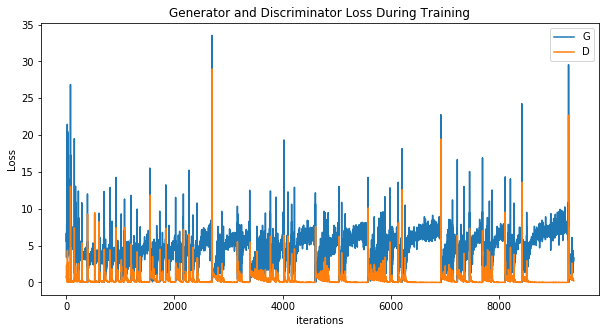

In [12]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

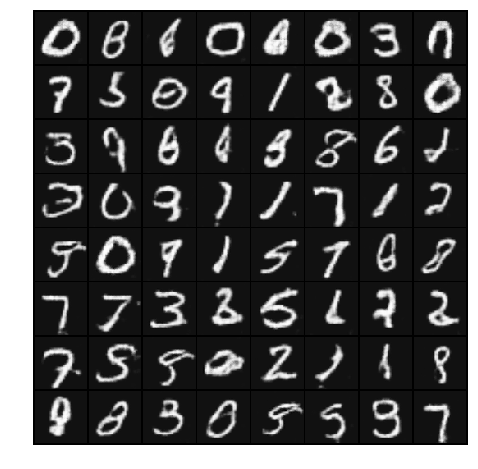

In [13]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())